In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import random
import string

In [177]:
from scipy.sparse import random as sparse_random

In [179]:
from scipy import stats

In [223]:
import scipy.sparse as sps

In [180]:
from sklearn.preprocessing import normalize

In [181]:
import json

In [182]:
from tqdm import tqdm_notebook

In [183]:
%matplotlib inline
import matplotlib.pyplot as plt

# Genesis parsing

In [184]:
cyber_distribution = json.load(open("./data/cyber_distribution.json"))

In [185]:
del cyber_distribution["total"]

In [186]:
cyber_distribution

{'cosmos_drop': '5000000000',
 'cybercongress': '4',
 'ethereum_drop': '10000000000',
 'foundation_auction_multisig': '60',
 'game_of_thrones': '20',
 'inventors': '2',
 'investors': '5',
 'pre_genesis_round': '5',
 'validators_drop': '2700000000000'}

In [235]:
cyber_distribution = {'cosmos_drop': '5000000000',
 'cybercongress': '4000000000',
 'ethereum_drop': '10000000000',
 'foundation_auction_multisig': '60000000000',
 'game_of_thrones': '20000000000',
 'inventors': '2000000000',
 'investors': '5000000000',
 'pre_genesis_round': '5000000000',
 'validators_drop': '27000000000'}

TODO define cosmos and ethereum groups from genesis

In [1066]:
synth_genesis = []
group_size = 1000

In [1067]:
for group, amount in cyber_distribution.items():
    amount = int(amount)
    for i in range(group_size):
        agent_params = {
            'group': group,
            'balance': amount / group_size,
            'address': group + str(i)
        }
        synth_genesis.append(agent_params)

In [1068]:
block_chunk = 1

Аккаунт + количество монет + когорта

# Model definitions

1. Balances are changing
2. Dynamic parameters are chaning
3. Bondings are changing
4. Total inflation is changing

In [851]:
def random_string(string_length=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

146 default validators

Proposals!?

In [852]:
class FastUtils:    
    # TODO remove duplicates from Agent class
    max_comission_rate = 0.1
    claim_probability = 0.01
    transaction_probability = 0.00001
    
    max_transaction_rate = 1
    
    def __init__(self, network):
        self.network = network
        if len(self.network.agents):
            self.density = self.transaction_probability / len(network.agents) * self.network.blocks_per_iteration
    
    def _create_balances(self):
        return np.array([agent.balance for agent in self.network.agents])
    
    def _set_balances(self, balances):
        for index, agent in enumerate(self.network.agents):
            agent.balance = balances[index]
            
    def _set_total_comission(self, comission):
        self.network.transactions_reward = comission
    
    def create_similar_random_matrix(self, coo_matrix):
        rows = coo_matrix.tocoo().row
        cols = coo_matrix.tocoo().col
        data = np.random.rand(len(rows))
        return sps.coo_matrix((data, (rows, cols)), shape=coo_matrix.shape)
    
    def do_random_transactions(self):
        assert self.density > 0, "Transactions density is insignificant"
        balances = self._create_balances()
        agents_size = balances.shape[0]
        
        random_max_transaction_rates = self.max_transaction_rate * np.random.rand(balances.shape[0])
        random_total_transaction_rates = sparse_random(agents_size, agents_size, density=self.density)
        normalized_random_total_transaction_rates = normalize(random_total_transaction_rates, norm='l1', axis=1)
        total_transaction_amounts = normalized_random_total_transaction_rates.T.multiply(random_max_transaction_rates * balances).T

        transactions_sended = (total_transaction_amounts > 0)
        random_comission_rates = self.max_comission_rate * self.create_similar_random_matrix(transactions_sended)
        comission_amounts = total_transaction_amounts.multiply(random_comission_rates)
        transaction_amounts = total_transaction_amounts - comission_amounts

        income = transaction_amounts.sum(axis=0).A1
        outcome = transaction_amounts.sum(axis=1).A1 + comission_amounts.sum(axis=1).A1
        new_balances = balances + income - outcome
        total_comission = comission_amounts.sum()
        
        self._set_balances(balances)
        self._set_total_comission(total_comission)

In [1028]:
class Network():
    # Constants
    blocks_per_year = 1/3 * 60 * 60 * 24 * 365 
    max_inflation = 0.12
    min_inflation = 0.05
    inflation_rate = 0.01
    start_inflation = 0.01
    bonding_goal = 0.9
    blocks_per_iteration = 1/3 * 60 * 60 * 24 * 30
    new_agents_per_iteration = 0.001
    
    # Class fields
    block = -1
    transactions_reward = 0 # Multiple transactions
    total_bonding = 0
    total_balance = 0
    stats = None
    
    @classmethod
    def from_json(self, description, validators=100):
        network = Network(validators, len(description))
        network.agents = []
        for agent_description in description:
            agent = Agent.from_json(network, agent_description)
            network.agents.append(agent)
            # TODO add default agent for this
            network.total_balance += agent.genesis_part
        return network
    
    def _create_validators(self):
        self.validators = []
        # TODO increase validators per year
        for i in range(self.validators_amount):
            validator = Validator(self)
            self.validators.append(validator)
    
    def _create_agents(self):
        self.agents = []
        for i in range(self.agents_amount):
            agent = Agent(self)
            self.agents.append(agent)
            
    def _initialize_fast_utils(self):
        self.fast_utils = FastUtils(self)
    
    def __init__(self, validators_amount, agents_amount):
        self.validators_amount = validators_amount
        self.agents_amount = agents_amount
        self.inflation = self.start_inflation
        self._create_validators()
        self._create_agents()
        self._initialize_fast_utils()
        
    def _change_inflation(self):
        if (self.block == 0) or ((self.block // self.blocks_per_iteration) % (self.blocks_per_year // self.blocks_per_iteration) != 0):
            return
        
        current_bonding_rate = self.total_bonding / self.total_balance
        
        if (self.bonding_goal < current_bonding_rate):
            self.inflation -= self.inflation_rate
        else:
            self.inflation += self.inflation_rate
        self.inflation = max(self.min_inflation, min(self.max_inflation, self.inflation))
    
    def _increase_block(self):
        self.block += self.blocks_per_iteration
        self._change_inflation()
        self.transactions_reward = 0
        self.block_reward = self.inflation * self.total_balance / self.blocks_per_year * self.blocks_per_iteration
        
    def _act_validators(self):
        self.total_balance += self.block_reward
        for validator in tqdm_notebook(self.validators):
            validator.act()
    
    def _add_new_agents(self):
        new_agens_amount = int(self.agents_amount * self.new_agents_per_iteration)
        self.agents_amount += new_agens_amount
        for i in range(new_agens_amount):
            agent = Agent(self)
            agent.group = "new_agents"
            agent.genesis_part = 0
            agent.balance = 0
            self.agents.append(agent)
            
    def _act_agents(self):
        for agent in tqdm_notebook(self.agents):
            agent.act()
        self.fast_utils.do_random_transactions()
        self._add_new_agents()
            
    def _update_stats(self):
        self.stats = {}
        for agent in self.agents:
            self.stats[agent.group] = self.stats.get(agent.group, 0) + agent.balance
        for agent in self.agents:
            self.stats["unclaimed_" + agent.group] = self.stats.get("unclaimed_" + agent.group, 0) + agent.genesis_part
        self.stats["inflation"] = self.inflation
        self.stats["total_balance"] = self.total_balance
        self.stats["total_bonding"] = self.total_bonding
            
    def act(self):
        self._increase_block()
        self._act_agents()
        self._act_validators()
        self._update_stats()
    
    # TODO These methods should be moved to proper locations

    def get_random_agent(self):
        return np.random.choice(self.agents)
    
    def get_random_validator(self):
        return np.random.choice(self.validators)
    
    def send_transaction(self, sender, receiver, amount, comission):
        assert sender.balance >= amount + comission
        sender.balance -= amount + comission
        receiver.balance += amount
        self.transactions_reward += comission
        
    def bond_validator(self, agent, validator, new_stake):
        old_stake = validator.bonding.get(agent, 0)
        difference = new_stake - old_stake
        assert agent.balance >= difference
        agent.balance -= difference
        validator.bonding[agent] = new_stake
        validator.total_bonding += difference
        self.total_bonding += difference
        
    def get_voting_power(self, validator):
        # TODO add cache for voting power
        return validator.total_bonding / (self.total_bonding + 0.00000001)
    
    def claim_tokens(self, agent, amount):
        assert agent.genesis_part >= amount
        agent.balance += amount
        agent.genesis_part -= amount
        
    def send_reward(self, validator, agent, rate):
        agent.balance += validator.reward * rate

In [1029]:
class NetworkParticipant():
    network = None
    id = None
    
    def __init__(self, network):
        self.network = network
        self.id = random_string()

Agent:
- Genesis state
- Balance (total, bonded)
- Transaction probability
- Bonded validators
- Sended transactions

Each block for agent
1. Claim the rest of tokens
2. Do random transactions 
3. Get reward from validators 
4. Rebond tokens

For the cohort of agents:
1. Increase total amount of a cohort
2. Save cohort amount for a block
3. Use genesis file to define group size

In [1030]:
class Agent(NetworkParticipant):
    group = None
    
    # Constants
    # Define constants with high influence on results
    max_comission_rate = 0.1
    claim_probability = 0.01
    transaction_probability = 0.9
    rebond_probability = 0.1
    
    # Dynamic parameters
    genesis_part = 0
    balance = 0
    
    @classmethod
    def from_json(cls, network, description):
        agent = Agent(network)
        agent.genesis_part = description['balance']
        agent.group = description['group']
        agent.id = description['address']
        return agent
    
    def __init__(self, network, genesis_part=100):
        super().__init__(network)
        self.genesis_part = genesis_part
        
    def _claim(self):
        # TODO claim comission
        # Periodically
        if np.random.rand() > self.claim_probability:
            return
        
        amount = np.random.rand() * self.genesis_part
        self.network.claim_tokens(self, amount)
    
    def _do_random_transaction(self):
        if np.random.rand() > self.transaction_probability:
            return
        
        receiver = self
        while receiver == self:
            receiver = self.network.get_random_agent()
        total_amount = np.random.rand() * self.balance
        comission = np.random.rand() * self.max_comission_rate * total_amount
        amount = total_amount - comission
        self.network.send_transaction(self, receiver, amount, comission)
     
    # rename to "delegate"
    def _rebond_tokens(self):
        if np.random.rand() > self.rebond_probability:
            return
        
        validator = self.network.get_random_validator()
        amount = np.random.rand() * self.balance
        self.network.bond_validator(self, validator, amount)
    
    def act(self):
        self._claim()
        # TODO no need in this method for now
#         self._do_random_transaction()
        self._rebond_tokens()

Validator:
- Comission
- Voting power
- Slowness probability
- Double-spend probability

Each block for validator:
1. Create
2. Update comission
3. Gather all transactions reward
4. Receive block reward depending on voting power
5. Do random event (nothing, double-spend, slowness)

Validator = agent

In [1031]:
class Validator(NetworkParticipant):
    # Dynamic parameters
    comission_rate = 0
    total_bonding = 0
    reward = 0
    
    def __init__(self, network):
        super().__init__(network)
        self.bonding = {}
    
    def _update_comission(self):
        self.comission_rate = np.random.rand()
        
    def _receive_reward(self):
        voting_power = self.network.get_voting_power(self)
        self.reward = voting_power * (self.network.block_reward + self.network.transactions_reward)
        # TODO move part of reward to validator's owner
        self.reward = (1 - self.comission_rate) * self.reward
        
    def _broadcast_reward(self):
        for agent, stake in self.bonding.items():
            rate = stake / (self.total_bonding + 0.000001)
            self.network.send_reward(self, agent, rate)
            
    def act(self):
        self._update_comission()
        self._receive_reward()
        self._broadcast_reward()

# Tests

In [1032]:
def assert_catch_exception(test_function, exception_class):
    exception_caught = False
    try:
        test_function()
    except exception_class:
        exception_caught = True
    assert exception_caught

## Network

Network should be created from json

In [1033]:
network = Network.from_json([{
    "address": "0x1",
    "balance": 1,
    "group": "test"
}], 5)

assert len(network.agents) == 1
assert network.agents[0].network == network
assert len(network.validators) == 5
assert network.total_balance == 1

Network should create validators and agents when created

In [1034]:
network = Network(1, 1)

assert len(network.validators) == 1
assert len(network.agents) == 1

Network should send transactions

In [1035]:
network = Network(1, 1)

sender = Agent(network)
sender.balance = 100

receiver = Agent(network)
receiver.balance = 10

network.send_transaction(sender, receiver, 10, 10)
assert sender.balance == 100 - 20
assert receiver.balance == 10 + 10
assert network.transactions_reward == 10

network.send_transaction(sender, receiver, 80, 0)
assert_catch_exception(
    lambda: network.send_transaction(sender, receiver, 80, 10),
    AssertionError
)

Network should bond agent stake to validators

In [1036]:
network = Network(1, 1)

validator = Validator(network)
assert not validator.bonding

agent = Agent(network)
agent.balance = 100

network.bond_validator(agent, validator, 20)
assert validator.bonding[agent] == 20
assert agent.balance == 100 - 20
assert validator.total_bonding == 20
assert network.total_bonding == 20

network.bond_validator(agent, validator, 10)
assert validator.bonding[agent] == 10
assert agent.balance == 100 - 10
assert validator.total_bonding == 10
assert network.total_bonding == 10

network.bond_validator(agent, validator, 100)
assert_catch_exception(
    lambda: network.bond_validator(agent, validator, 110),
    AssertionError
)

Network should return voting power for each validator

In [1037]:
network = Network(1, 1)

validator1 = Validator(network)
validator2 = Validator(network)

agent1 = Agent(network)
agent1.balance = 100

agent2 = Agent(network)
agent2.balance = 100

agent3 = Agent(network)
agent3.balance = 100

network.bond_validator(agent1, validator1, 10)
network.bond_validator(agent2, validator1, 10)
network.bond_validator(agent3, validator2, 10)

# print(network.get_voting_power(validator1))
assert np.abs(network.get_voting_power(validator1) - 20 / 30) < 0.001
assert np.abs(network.get_voting_power(validator2) - 10 / 30) < 0.001

Network should send reward from validator to agent

In [1038]:
network = Network(1, 1)

validator = Validator(network)
validator.reward = 200

agent = Agent(network)
agent.balance = 10

network.send_reward(validator, agent, 0.1)

assert agent.balance == 10 + 0.1 * 200

Network should increase block

In [1039]:
network = Network(1, 1)
network.blocks_per_iteration = 1

network._increase_block()
assert network.block == 0

network._increase_block()
assert network.block == 1

Network should reset transactions reward after increase

In [1040]:
network = Network(1, 1)
network.blocks_per_iteration = 1
network.transactions_reward = None

network._increase_block()
assert network.transactions_reward == 0

Network should recount block reward after increase

In [1041]:
network = Network(1, 1)
network.inflation = 0.1
network.blocks_per_year = 2
network.total_balance = 100
network.block_reward = None
network.blocks_per_iteration = 1

network._increase_block()
assert network.block_reward == 0.1 * 100 / 2

Network should recount inflation each year depending on total bonding and total balance

In [1042]:
network = Network(1, 1)
network.blocks_per_iteration = 1
network.inflation = 0.1
network.max_inflation = 0.2
network.min_inflation = 0.0
network.inflation_rate = 0.1
network.blocks_per_year = 2
network.bonding_goal = 0.5

network.total_bonding = 0
network.total_balance = 100

# Initial inflation is equal to start one
network._increase_block()
assert network.inflation == 0.1

# Do not change inflation during a year
network._increase_block()
assert network.inflation == 0.1

# Increase inflation by defined rate when bonding rate is too low
network._increase_block()
assert network.inflation == 0.1 + 0.1

# Do not change inflation more than max
network._increase_block()
network._increase_block()
assert network.inflation == 0.2

network.total_bonding = 55
network.total_balance = 100

# Decrease inflation by defined rate when bonding rate is too low
network._increase_block()
network._increase_block()
network._increase_block()
network._increase_block()
assert network.inflation == 0.2 - 0.1 - 0.1

# Do not change inflation less than min
network._increase_block()
network._increase_block()
assert network.inflation == 0.0

Network should return random agent

In [1043]:
network = Network(1, 2)
assert network.get_random_agent() in network.agents

Network should return random validator

In [1044]:
network = Network(2, 1)
assert network.get_random_validator() in network.validators

Network should claim agent tokens

In [1045]:
network = Network(1, 1)
agent = Agent(network)
agent.genesis_part = 10

network.claim_tokens(agent, 5)
assert agent.genesis_part == 5
assert agent.balance == 5

assert_catch_exception(
    lambda: network.claim_tokens(agent, 6),
    AssertionError
)

Network should count statistics by groups after each iteration

In [1046]:
network = Network(1, 1)
agent = network.agents[0]
agent.balance = 10
agent.group = "test"

network._update_stats()
assert network.stats["test"] == 10

## Agent

Agent should send nonzero random transaction to another agent

In [1047]:
# Deprecated: this method has an accelerated implementation

network = Network(1, 2)
agent = network.agents[0]

agent.transaction_probability = 1
agent.balance = 100
old_balance = agent.balance

agent._do_random_transaction()
    
assert agent.balance < 100
assert network.agents[1].balance > 0

Agent should rebond tokens randomly

In [1048]:
network = Network(1, 1)
agent = network.agents[0]
validator = network.validators[0]

agent.rebond_probability = 1
agent.balance = 100
old_balance = agent.balance

agent._rebond_tokens()
    
assert agent.balance < 100
assert validator.bonding[agent] > 0

Agent should claim tokens

In [1049]:
network = Network(1, 1)
agent = network.agents[0]
assert agent.balance == 0

agent.claim_probability = 1
agent.genesis_part = 100

agent._claim()
    
assert agent.balance > 0
assert agent.genesis_part < 100

Agent should create itself from json description

In [1050]:
network = Network(0, 0)
agent = Agent.from_json(network, {
    'address': "0x1",
    'group': "test",
    "balance": 110
})
assert agent.genesis_part == 110
assert agent.group == "test"
assert agent.id == "0x1"
assert agent.network == network

## Validator

Validator should update comission

In [1051]:
network = Network(1, 1)
validator = network.validators[0]

old_comission_rate = validator.comission_rate

validator._update_comission()
assert validator.comission_rate != old_comission_rate

Validator should receive reward

In [1052]:
network = Network(1, 1)
validator = network.validators[0]
network.get_voting_power = lambda x: 0.1
network.block_reward = 100
network.transactions_reward = 200
validator.comission_rate = 0.1

validator._receive_reward()
assert round(validator.reward) == round((1 - 0.1) * 0.1 * (100 + 200))

Validator should send reward to all bonded agents depending on their rates

In [1053]:
network = Network(1, 2)
validator = network.validators[0]
agent1 = network.agents[0]
agent2 = network.agents[1]

agent1.balance = 100
agent2.balance = 100

network.bond_validator(agent1, validator, 1)
network.bond_validator(agent2, validator, 4)

validator.reward = 20

validator._broadcast_reward()
assert np.abs(agent1.balance - ((100 - 1) + 20 * 1 / 5)) < 0.0001
assert np.abs(agent2.balance - ((100 - 4) + 20 * 4 / 5)) < 0.0001

# Big network evaluation

In [1072]:
network = Network.from_json(synth_genesis, 146)

In [1073]:
all_stats = []
for i in tqdm_notebook(range(1000)):
    network.act()
#     print(network.stats)
    all_stats.append(network.stats.copy())

In [1077]:
network.stats

{'cosmos_drop': 8049260666056.113,
 'cybercongress': 7988686104074.526,
 'ethereum_drop': 15291010732560.104,
 'foundation_auction_multisig': 88679073929785.45,
 'game_of_thrones': 30169379520342.54,
 'inflation': 0.12,
 'inventors': 12960631834207.422,
 'investors': 8879237005557.791,
 'new_agents': 0.0,
 'pre_genesis_round': 8676432931742.998,
 'total_balance': 1920161850579466.2,
 'total_bonding': 1002273266379020.8,
 'unclaimed_cosmos_drop': 28865469.534483645,
 'unclaimed_cybercongress': 28930720.25665247,
 'unclaimed_ethereum_drop': 98044263.40392408,
 'unclaimed_foundation_auction_multisig': 400609769.0773327,
 'unclaimed_game_of_thrones': 130782744.66151533,
 'unclaimed_inventors': 12997185.75753914,
 'unclaimed_investors': 38533874.22334543,
 'unclaimed_new_agents': 0.0,
 'unclaimed_pre_genesis_round': 32321926.026869282,
 'unclaimed_validators_drop': 216765312.7854869,
 'validators_drop': 34692663028199.836}

# Visualization

### Balances by groups

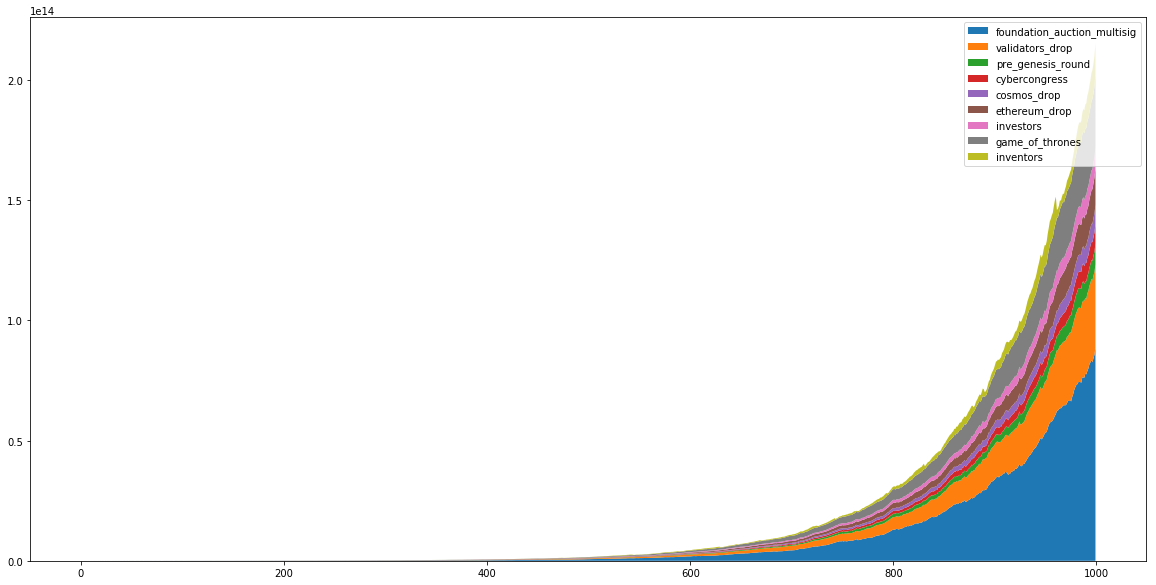

In [1079]:
plt.figure(figsize=(20, 10))
x = range(len(all_stats))
y = np.array([
    [stat[group] for stat in all_stats]
    for group in cyber_distribution
])

# y = y / y.sum(axis=0)
labels = [group for group in cyber_distribution]
 
plt.stackplot(x, y, labels=labels)
plt.legend()
plt.show()

### Tokens unclaimed

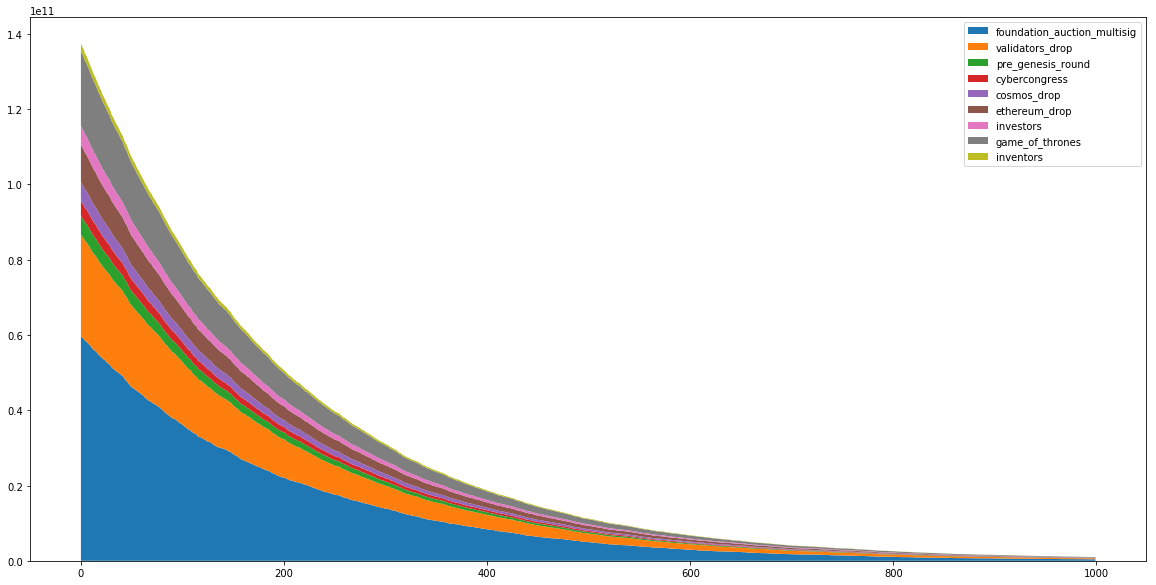

In [1075]:
plt.figure(figsize=(20, 10))
x = range(len(all_stats))
y = [
    [stat["unclaimed_" + group] for stat in all_stats]
    for group in cyber_distribution
]
labels = [group for group in cyber_distribution]
 
plt.stackplot(x, y, labels=labels)
plt.legend()
plt.show()

### Inflation and bonding

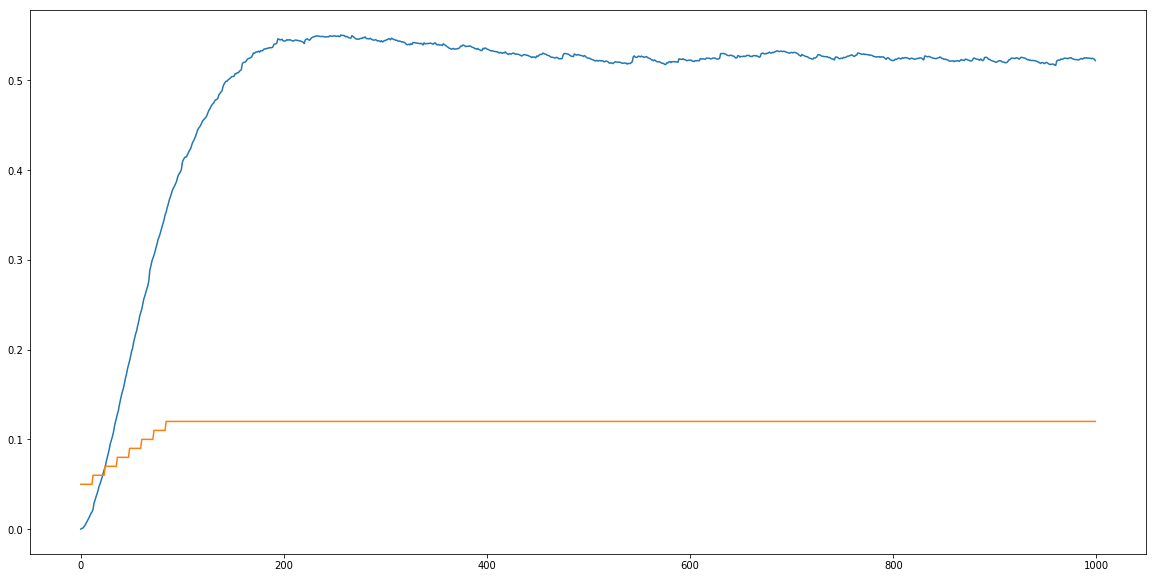

In [1076]:
plt.figure(figsize=(20, 10))
x = range(len(all_stats))
bonding_rate_y = [stat["total_bonding"] / stat["total_balance"] for stat in all_stats]
inflation_y = [stat["inflation"] for stat in all_stats]

plt.plot(x, bonding_rate_y)
plt.plot(x, inflation_y)
plt.show()

Доработки
- Нет агента, который получал бы комиссию от валидатора

Баги
- Новые агенты не получают транзакции
- Claimed и unclaimed не совпадают